<a href="https://colab.research.google.com/github/alexandergribenchenko/Data_Science_Toolkit/blob/main/Pipelines/nb_netplan_cam_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Parametros

## 01.01. Parametros pipeline anterior

In [ ]:
dbutils.widgets.text('last_date','')
last_date = dbutils.widgets.get('last_date')
print(last_date)

20230115


## 01.02. Parametros pipeline anterior

In [ ]:
%run "./nb_netplan_cam_medians"

In [ ]:
df_median_threshold

,airline_code,rt,median_asks_hist,median_lower_thresh_hist,median_upper_thresh_hist
0,2D,GYEJFK,2293508.32,458701.664,4.128315e+06
1,4J,CURMDE,1331957.52,266391.504,2.397524e+06
2,5U,CUNGUA,3510945.00,702189.000,6.319701e+06
3,5U,FRSGUA,6315452.40,1263090.480,1.136781e+07
4,5U,GUASAL,427454.66,85490.932,7.694184e+05
...,...,...,...,...,...
504,Y4,MEXSJO,16491012.60,3298202.520,2.968382e+07
505,Y4,MIASAP,6739894.20,1347978.840,1.213181e+07
506,Y4,RTBSAL,1400901.84,280180.368,2.521623e+06
507,Y4,SALSAP,1229680.40,245936.080,2.213425e+06


In [ ]:
percentage_threshold

Out[39]: 0.8

## 01.03. Paths datalake

In [ ]:
path_delta_input= 'abfss://harmonized@azdlkbidev.dfs.core.windows.net/network-planning/schedules-data/schedules_data_snapshot'
path_parquet_output = f'abfss://curated@azdlkbidev.dfs.core.windows.net/ADV/network-planning/schedules-data/competitor_alerts_parquet/output_competitor_alerts_{last_date}/'

# 02. Librerías

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import time
start_time=time.time()

# 03. Carga de la tabla delta

In [ ]:
spark.conf.set("fs.azure.account.key.azdlkbidev.dfs.core.windows.net",dbutils.secrets.get(scope="scKyADV",key="KvADLSKey"))
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set("spark.sql.session.timeZone", "EST")
spark.conf.set("spark.sql.session.timeZone", "EST")
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [ ]:
path_delta_input

Out[44]: 'abfss://harmonized@azdlkbidev.dfs.core.windows.net/network-planning/schedules-data/schedules_data_snapshot'

In [ ]:
df_delta = spark.read.load(path_delta_input, 
                           format='delta', 
                           inferSchema='False', 
                           encoding='UTF-8', 
                           header="True")

In [ ]:
# df_delta.printSchema()

In [ ]:
df_delta.limit(5).toPandas()

,flight_date,airline_code,flight,origin_code,thru_point_code,destination_code,dep_time,arr_time,service_type,equipment_code,seats,asks,block_mins,seats_economy,file_name,snapshot_date,od,rt,op_av
0,20220101,2D,162,MIA,,ASU,0110,1110,Sched. Pax,763,261,1606228.32,480,245,Schedule_Dynamic_Table_Report_220213.tsv,20220213,MIAASU,ASUMIA,N
1,20220101,2D,322,JFK,,GYE,0655,1335,Sched. Pax,763,240,1146754.16,400,212,Schedule_Dynamic_Table_Report_220213.tsv,20220213,JFKGYE,GYEJFK,Y
2,20220101,2D,323,GYE,,JFK,1625,2305,Sched. Pax,763,240,1146754.16,400,212,Schedule_Dynamic_Table_Report_220213.tsv,20220213,GYEJFK,GYEJFK,Y
3,20220101,2I,2123,LIM,,CIX,0755,0910,Sched. Pax,733,143,93205.16,75,0,Schedule_Dynamic_Table_Report_220213.tsv,20220213,LIMCIX,CIXLIM,N
4,20220101,2I,2124,CIX,,LIM,0945,1100,Sched. Pax,733,143,93205.16,75,0,Schedule_Dynamic_Table_Report_220213.tsv,20220213,CIXLIM,CIXLIM,N


In [ ]:
# print(sorted([i.snapshot_date for i in df_delta.select('snapshot_date').distinct().collect()]))

In [ ]:
print(sorted([i.airline_code for i in df_delta.select('airline_code').distinct().collect()]))

['2D', '2I', '2M', '2W', '2Z', '4A', '4J', '4Y', '5R', '5U', '7P', '7Z', '9A', '9N', '9R', '9V', 'AA', 'ABJ', 'AC', 'AD', 'AF', 'AM', 'ANS', 'AR', 'AS', 'AV', 'AZ', 'B6', 'BA', 'BW', 'CC', 'CM', 'CU', 'DL', 'DM', 'E4', 'E9', 'ECO', 'EK', 'EO', 'ES', 'ET', 'F9', 'FO', 'G3', 'GL', 'GW', 'H2', 'H8', 'HN', 'IB', 'JA', 'JY', 'JZ', 'KL', 'KX', 'LA', 'LH', 'LX', 'N3', 'N4', 'NIS', 'NK', 'OB', 'OR', 'P5', 'PU', 'PY', 'Q6', 'QL', 'RZ', 'S0', 'S6', 'SY', 'T9', 'TA', 'TK', 'TOM', 'TP', 'TS', 'TX', 'U0', 'UA', 'ULS', 'UX', 'V0', 'V5', 'VB', 'VE', 'VH', 'VNE', 'VV', 'VW', 'W2', 'WG', 'WJ', 'WN', 'WS', 'WW', 'XL', 'Y2', 'Y4', 'Z8', 'ZP']


# 03. Transformadores

## 03.01. FeatureSelector

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_FeatureSelector):
        self.feature_names = params_FeatureSelector['feature_names'] 
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
      X_output = X.select(self.feature_names)
      return X_output

## 03.02. FilterDates

In [ ]:
class FilterDates(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_FilterDates):
      self.column = params_FilterDates['column']
      self.last_date = params_FilterDates['last_date'] 
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
      delta_all_dates = sorted([i.snapshot_date for i in X.select('snapshot_date').distinct().collect()])
      dates_to_select = [delta_all_dates[delta_all_dates.index(self.last_date)-1], delta_all_dates[delta_all_dates.index(self.last_date)]]
      X_output = X.filter(X[self.column].isin(dates_to_select))
      return X_output

## 03.03. FilterOpAv

In [ ]:
class FilterOpAv(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_FilterDates):
      self.column = params_FilterOpAv['column']
      self.op_av_option = params_FilterOpAv['op_av_option']
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
      X_output = X.filter(X[self.column]==self.op_av_option )
      return X_output

## 03.04. SparkToPandas

In [ ]:
class SparkToPandas(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_SparkToPandas):
      self.empty = params_SparkToPandas
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
      X_output = X.toPandas()
      return X_output

## 03.05. ChangeAirlineCode

In [ ]:
class ChangeAirlineCode(BaseEstimator, TransformerMixin):
    
  def __init__(self, params_ChangeAirlineCode):
      self.cols_to_trans = params_ChangeAirlineCode['cols_to_trans']
      self.dict_replace = params_ChangeAirlineCode['dict_replace']
    
  def fit(self, X, y = None):
      return self 
    
  def transform(self, X, y = None):
    X_output = X.copy()
    for col_i in self.cols_to_trans:
      X_output = X_output.replace({col_i: self.dict_replace})
    return X_output

## 03.06. DateFormatTransformer

In [ ]:
class DateFormatTransformer(BaseEstimator, TransformerMixin):
    
  def __init__(self, params_DateFormatTransformer):
      self.cols_to_trans = params_DateFormatTransformer['cols_to_trans'] 
    
  def fit(self, X, y = None):
      return self 
    
  def transform(self, X, y = None):
    X_output = X.copy()
    for col_i in self.cols_to_trans:
      X_output[col_i] = X_output[col_i].apply(lambda x: x[:6])
    return X_output

## 03.07. AskAggregator

In [ ]:
class AskAggregator(BaseEstimator, TransformerMixin):
    
  def __init__(self, params_DateFormatTransformer):
      self.cols_to_agg = params_DateFormatTransformer['cols_to_agg'] 
    
  def fit(self, X, y = None):
      return self 
    
  def transform(self, X, y = None):
    X_output = X.copy()
    X_output = X_output.groupby(self.cols_to_agg, as_index=False).\
                         agg(sum_asks = ('asks', 'sum'))
    return X_output

## 03.07.B. MedianThreshold

In [ ]:
class MedianThreshold(BaseEstimator, TransformerMixin):
    
  def __init__(self, params_MedianThreshold):
      self.df_median_threshold = params_MedianThreshold['df_median_threshold'] 
    
  def fit(self, X, y = None):
      return self 
    
  def transform(self, X, y = None):
#     X_output = X.copy()
    X_output = pd.merge(X, self.df_median_threshold, on=['airline_code','rt'], how='left')
    return X_output

In [ ]:
# df_merged = pd.merge(df,df_median_threshold, on=['airline_code','rt'], how='left')
# df_merged

## 03.08. RcsCalculator

In [ ]:
class RcsCalculator(BaseEstimator, TransformerMixin):
    
  def __init__(self, params_RcsCalculator):
      self.empty = params_RcsCalculator 
    
  def fit(self, X, y = None):
      return self 
    
  def transform(self, X, y = None):

    df_av = X[X['airline_code']=='AV'].groupby(['snapshot_date', 
                                              'rt', 
                                              'flight_date'], as_index=False).\
                                     agg(total_asks_av = ('sum_asks', 'sum'), 
                                         median_asks_hist_av = ('median_asks_hist', 'median'),
                                         median_lower_thresh_hist_av = ('median_lower_thresh_hist', 'median'), 
                                         median_upper_thresh_hist_av = ('median_upper_thresh_hist', 'median'))
    
    df_competitors = X[X['airline_code']!='AV'].groupby(['snapshot_date', 
                                              'rt', 
                                              'flight_date', 
                                              'airline_code'], as_index=False).\
                                     agg(total_asks_competitor = ('sum_asks', 'sum'), 
                                         median_asks_hist_competitor = ('median_asks_hist', 'median'),
                                         median_lower_thresh_hist_competitor = ('median_lower_thresh_hist', 'median'), 
                                         median_upper_thresh_hist_competitor = ('median_upper_thresh_hist', 'median'))
    
    df_competitors_max = df_competitors.loc[df_competitors.groupby(['snapshot_date', 'rt', 'flight_date'])\
                                                       ['total_asks_competitor'].idxmax()].\
                                                       reset_index(drop=True).\
                                                       rename(columns={'airline_code':'competitor', 
                                                                       'total_asks_competitor': 'max_asks_competitor'})
    
    X_output = df_av.merge(df_competitors_max,  how='left', on=['snapshot_date', 'rt', 'flight_date'])
    X_output['rcs']= round(X_output['total_asks_av']/X_output['max_asks_competitor'],2)

    return X_output

In [ ]:
# df

In [ ]:
df

,airline_code,rt,flight_date,snapshot_date,sum_asks
0,2D,GYEJFK,202201,20220131,38989641.44
1,2D,GYEJFK,202201,20220213,38989641.44
2,2D,GYEJFK,202201,20220227,38989641.44
3,2D,GYEJFK,202202,20220131,17201312.40
4,2D,GYEJFK,202202,20220213,17201312.40
...,...,...,...,...,...
144757,Y4,SALSJO,202401,20230212,2440280.44
144758,Y4,SALSJO,202401,20230219,2440280.44
144759,Y4,SALSJO,202401,20230226,2440280.44
144760,Y4,SALSJO,202401,20230305,2440280.44


## 03.09. CategoryCalculator

In [ ]:
class CategoryCalculator(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_CategoryCalculator):
      self.intervals_values = params_CategoryCalculator['intervals_values'] 
      self.intervals_names = params_CategoryCalculator['intervals_names']
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
      X_output = X.copy()
      
      bins = pd.IntervalIndex.from_tuples(self.intervals_values, closed='left')
      categorias = self.intervals_names
      
      X_output['category'] = pd.Series(np.array(categorias)[pd.cut(X_output['rcs'], bins = bins).cat.codes], index=X_output.index)
      
      indx_competitor_NaN = X_output[X_output.competitor.isnull()].index
      indx_competitor_NaN
      X_output['category'][indx_competitor_NaN] = 'Sole_Player'
      
      return X_output

In [ ]:
df.head(3)

,airline_code,rt,flight_date,snapshot_date,sum_asks
0,2D,GYEJFK,202201,20220131,38989641.44
1,2D,GYEJFK,202201,20220213,38989641.44
2,2D,GYEJFK,202201,20220227,38989641.44


## 03.10. ChangeCategoryCalculator

In [ ]:
class ChangeCategoryCalculator(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_ChangeCategoryCalculator):
      self.empty = params_ChangeCategoryCalculator
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):

      list_last_dates = sorted(list(X.snapshot_date.unique()))[-2:]

      df_cw = X[X.snapshot_date==list_last_dates[1]]
      df_lw = X[X.snapshot_date==list_last_dates[0]]

      df_merge = df_cw.merge(df_lw, how='inner', on = ['rt', 'flight_date'], suffixes=('_cw', '_lw'))
      df_merge['rcs_delta_abs'] = round(abs(df_merge['rcs_cw']-df_merge['rcs_lw']),2)

      cols_interest =  ['rt', 
                        'flight_date', 
                        'snapshot_date_lw',
                        'snapshot_date_cw',
                        'rcs_lw',
                        'rcs_cw',
                        'rcs_delta_abs',
                        'category_lw',
                        'category_cw',
                        'competitor_lw',
                        'competitor_cw', 
                        'total_asks_av_lw',
                        'total_asks_av_cw',
                        'max_asks_competitor_lw', 
                        'max_asks_competitor_cw', 
                        'median_asks_hist_av_lw',
                        'median_asks_hist_av_cw',
                        'median_lower_thresh_hist_av_lw',
                        'median_lower_thresh_hist_av_cw',
                        'median_upper_thresh_hist_av_lw',
                        'median_upper_thresh_hist_av_cw',
                        'median_asks_hist_competitor_lw',
                        'median_asks_hist_competitor_cw',
                        'median_lower_thresh_hist_competitor_lw',
                        'median_lower_thresh_hist_competitor_cw',
                        'median_upper_thresh_hist_competitor_lw',
                        'median_upper_thresh_hist_competitor_cw'
                       ]

      df_merge = df_merge[cols_interest]

      df_merge['change'] = df_merge.apply(lambda x: 'No_change' if x['category_cw'] == x['category_lw'] 
                                               else 'Upgrade'   if x['category_cw'] == 'Sole_Player'
                                               else 'Upgrade'   if x['rcs_cw'] > x['rcs_lw']
                                               else 'Downgrade', 
                                                        axis=1)

      X_output = df_merge[df_merge.change!='No_change'].\
                 sort_values(by=['rcs_delta_abs','rt'], ascending=[False,True]).\
                 reset_index(drop=True)
      
      return X_output

## 03.11. IdGenerator

In [ ]:
class IdGenerator(BaseEstimator, TransformerMixin):
    
  def __init__(self, params_DateFormatTransformer):
      self.empty = params_SparkToPandas
    
  def fit(self, X, y = None):
      return self 
    
  def transform(self, X, y = None):
    X_output = X.copy()
    cols= list(X_output.columns)
    cols_to_join = ['snapshot_date_cw', 'rt', 'flight_date']
    X_output['id_alert'] = X_output[cols_to_join].apply(lambda x: ''.join(x), axis=1)
    X_output = X_output[['id_alert']+cols]
    return X_output

# 04. Pipeline

## 04.01. Parameters

In [ ]:
params_FeatureSelector = {}
params_FeatureSelector['feature_names']= ['snapshot_date', 
                                          'flight_date',
                                          'rt', 
                                          'op_av', 
                                          'airline_code',
                                          'asks'
                                         ]

params_FilterDates = {}
params_FilterDates['column'] = 'snapshot_date'
params_FilterDates['last_date'] = last_date

params_FilterOpAv = {}
params_FilterOpAv['column'] = 'op_av'
params_FilterOpAv['op_av_option'] = 'Y'

params_SparkToPandas = {}

params_ChangeAirlineCode = {}
params_ChangeAirlineCode['cols_to_trans']= ['airline_code']
params_ChangeAirlineCode['dict_replace']= {'Q6': 'Y4', 
                                           'N3': 'Y4',
                                           'TA': 'AV',
                                           'VV': 'VH'}

params_DateFormatTransformer = {}
params_DateFormatTransformer['cols_to_trans']= ['flight_date']
params_DateFormatTransformer

params_AskAggregator = {}
params_AskAggregator['cols_to_agg'] = ['snapshot_date','flight_date', 'rt', 'airline_code']

params_MedianThreshold = {}
params_MedianThreshold['df_median_threshold'] = df_median_threshold

params_RcsCalculator = {}

params_CategoryCalculator = {}
params_CategoryCalculator['intervals_values'] = [(0, 0.4), (0.4, 0.7), (0.7, 1), (1, 1.5), (1.5, 1E10)]
params_CategoryCalculator['intervals_names'] = ['Bottom_Feeder','Challenger', 'Follower', 'Co_Leader', 'Leader']

params_ChangeCategoryCalculator = {}

params_IdGenerator = {}

## 04.02. Instantiated Transformers

In [ ]:
Transformer_FeatureSelector = FeatureSelector(params_FeatureSelector)
Transformer_FilterDates = FilterDates(params_FilterDates)
Transformer_FilterOpAv = FilterOpAv(params_FilterOpAv)
Transformer_SparkToPandas = SparkToPandas(params_SparkToPandas)
Transformer_ChangeAirlineCode = ChangeAirlineCode(params_ChangeAirlineCode)
Transformer_DateFormatTransformer = DateFormatTransformer(params_DateFormatTransformer)
Transformer_AskAggregator = AskAggregator(params_AskAggregator)
Transformer_MedianThreshold = MedianThreshold(params_MedianThreshold)
#
Transformer_RcsCalculator = RcsCalculator(params_RcsCalculator)
Transformer_CategoryCalculator = CategoryCalculator(params_CategoryCalculator)
Transformer_ChangeCategoryCalculator = ChangeCategoryCalculator(params_ChangeCategoryCalculator)
Transformer_IdGenerator = IdGenerator(params_IdGenerator)

## 04.03. Pipeline

In [ ]:
pipeline_mod_competitor_alerts = Pipeline(steps=[('NameFeatureSelector', Transformer_FeatureSelector),
                              ('NameFilterDates', Transformer_FilterDates),
                              ('NameFilterOpAv', Transformer_FilterOpAv),
                              ('NameSparkToPandas', Transformer_SparkToPandas),
                              ('NameDateFormatChangeAirlineCode', Transformer_ChangeAirlineCode),
                              ('NameDateFormatTransformer', Transformer_DateFormatTransformer),
                              ('NameAskAggregator', Transformer_AskAggregator),
                              ('NameMedianThreshold', Transformer_MedianThreshold), 
                              ('NameRcsCalculator', Transformer_RcsCalculator),
                              ('NameCategoryCalculator', Transformer_CategoryCalculator),
                              ('NameChangeCategoryCalculator', Transformer_ChangeCategoryCalculator), 
                              ('NameTransformer_IdGenerator', Transformer_IdGenerator)
                              ])

In [ ]:
df = pipeline_mod_competitor_alerts.transform(df_delta)
df

,id_alert,rt,flight_date,snapshot_date_lw,snapshot_date_cw,rcs_lw,rcs_cw,rcs_delta_abs,category_lw,category_cw,competitor_lw,competitor_cw,total_asks_av_lw,total_asks_av_cw,max_asks_competitor_lw,max_asks_competitor_cw,median_asks_hist_av_lw,median_asks_hist_av_cw,median_lower_thresh_hist_av_lw,median_lower_thresh_hist_av_cw,median_upper_thresh_hist_av_lw,median_upper_thresh_hist_av_cw,median_asks_hist_competitor_lw,median_asks_hist_competitor_cw,median_lower_thresh_hist_competitor_lw,median_lower_thresh_hist_competitor_cw,median_upper_thresh_hist_competitor_lw,median_upper_thresh_hist_competitor_cw,change
0,20230115MDERCH202302,MDERCH,202302,20230108,20230115,2.00,0.92,1.08,Leader,Follower,VH,VH,3763547.52,1735413.58,1881773.76,1881773.76,3159811.72,3159811.72,6.319623e+05,6.319623e+05,5.687661e+06,5.687661e+06,2822660.64,2822660.64,5.645321e+05,5.645321e+05,5.080789e+06,5.080789e+06,Downgrade
1,20230115CLOSMR202311,CLOSMR,202311,20230108,20230115,0.77,1.83,1.06,Follower,Leader,VH,LA,9403075.20,9403075.20,12223997.76,5150795.66,8744860.06,8744860.06,1.748972e+06,1.748972e+06,1.574075e+07,1.574075e+07,10970254.40,5150795.66,2.194051e+06,1.030159e+06,1.974646e+07,9.271432e+06,Upgrade
2,20230115CLOSMR202312,CLOSMR,202312,20230108,20230115,0.79,1.78,0.99,Follower,Leader,VH,LA,9716511.04,9716511.04,12223997.76,5453783.64,8744860.06,8744860.06,1.748972e+06,1.748972e+06,1.574075e+07,1.574075e+07,10970254.40,5150795.66,2.194051e+06,1.030159e+06,1.974646e+07,9.271432e+06,Upgrade
3,20230115BGACTG202302,BGACTG,202302,20230108,20230115,1.25,0.38,0.87,Co_Leader,Bottom_Feeder,U0,U0,3256024.80,976807.44,2604819.84,2604819.84,3256024.80,3256024.80,6.512050e+05,6.512050e+05,5.860845e+06,5.860845e+06,2767621.08,2767621.08,5.535242e+05,5.535242e+05,4.981718e+06,4.981718e+06,Downgrade
4,20230115GYEJFK202312,GYEJFK,202312,20230108,20230115,1.80,1.01,0.79,Leader,Co_Leader,B6,B6,30962362.32,30962362.32,17201312.46,30580111.04,30388985.24,30388985.24,6.077797e+06,6.077797e+06,5.470017e+07,5.470017e+07,59248965.14,59248965.14,1.184979e+07,1.184979e+07,1.066481e+08,1.066481e+08,Downgrade
5,20230115CTGPEI202311,CTGPEI,202311,20230108,20230115,0.89,1.67,0.78,Follower,Leader,VH,VH,11210690.40,11210690.40,12555972.80,6726414.00,11434904.16,11434904.16,2.286981e+06,2.286981e+06,2.058283e+07,2.058283e+07,8520124.40,8520124.40,1.704025e+06,1.704025e+06,1.533622e+07,1.533622e+07,Upgrade
6,20230115CTGPEI202312,CTGPEI,202312,20230108,20230115,0.92,1.67,0.75,Follower,Leader,VH,VH,11584380.08,11584380.08,12555972.80,6950627.80,11434904.16,11434904.16,2.286981e+06,2.286981e+06,2.058283e+07,2.058283e+07,8520124.40,8520124.40,1.704025e+06,1.704025e+06,1.533622e+07,1.533622e+07,Upgrade
7,20230115CTGJFK202312,CTGJFK,202312,20230108,20230115,1.67,0.94,0.73,Leader,Follower,B6,B6,16276358.16,16276358.16,9765814.86,17361448.64,16276358.16,16276358.16,3.255272e+06,3.255272e+06,2.929744e+07,2.929744e+07,33637806.74,33637806.74,6.727561e+06,6.727561e+06,6.054805e+07,6.054805e+07,Downgrade
8,20230115CLOPSO202301,CLOPSO,202301,20230108,20230115,1.83,1.15,0.68,Leader,Co_Leader,VE,VE,2672090.52,2851693.32,1460769.44,2478518.64,2366266.89,2366266.89,4.732534e+05,4.732534e+05,4.259280e+06,4.259280e+06,1269193.12,1269193.12,2.538386e+05,2.538386e+05,2.284548e+06,2.284548e+06,Downgrade
9,20230115CLOCTG202302,CLOCTG,202302,20230108,20230115,0.81,0.30,0.51,Follower,Bottom_Feeder,LA,LA,8308077.60,3046295.12,10223551.01,10223551.01,20770194.00,20770194.00,4.154039e+06,4.154039e+06,3.738635e+07,3.738635e+07,11779007.68,11779007.68,2.355802e+06,2.355802e+06,2.120221e+07,2.120221e+07,Downgrade


In [ ]:
df['suspicious'] = df.apply(lambda x: 'Not suspicious ' if x['median_lower_thresh_hist_av_lw']<=x['total_asks_av_lw']<=x['median_upper_thresh_hist_av_lw']
                                       and x['median_lower_thresh_hist_av_cw']<=x['total_asks_av_cw']<=x['median_upper_thresh_hist_av_cw']
                                       and x['median_lower_thresh_hist_competitor_lw']<=x['max_asks_competitor_lw']<=x['median_upper_thresh_hist_competitor_lw']
                                       and x['median_lower_thresh_hist_competitor_cw']<=x['max_asks_competitor_cw']<=x['median_upper_thresh_hist_competitor_cw']
                                       else 'Suspicious', 
                                                       axis=1)
df['threshold'] = percentage_threshold

df

,id_alert,rt,flight_date,snapshot_date_lw,snapshot_date_cw,rcs_lw,rcs_cw,rcs_delta_abs,category_lw,category_cw,competitor_lw,competitor_cw,total_asks_av_lw,total_asks_av_cw,max_asks_competitor_lw,max_asks_competitor_cw,median_asks_hist_av_lw,median_asks_hist_av_cw,median_lower_thresh_hist_av_lw,median_lower_thresh_hist_av_cw,median_upper_thresh_hist_av_lw,median_upper_thresh_hist_av_cw,median_asks_hist_competitor_lw,median_asks_hist_competitor_cw,median_lower_thresh_hist_competitor_lw,median_lower_thresh_hist_competitor_cw,median_upper_thresh_hist_competitor_lw,median_upper_thresh_hist_competitor_cw,change,suspicious,threshold
0,20230115MDERCH202302,MDERCH,202302,20230108,20230115,2.00,0.92,1.08,Leader,Follower,VH,VH,3763547.52,1735413.58,1881773.76,1881773.76,3159811.72,3159811.72,6.319623e+05,6.319623e+05,5.687661e+06,5.687661e+06,2822660.64,2822660.64,5.645321e+05,5.645321e+05,5.080789e+06,5.080789e+06,Downgrade,Not suspicious,0.8
1,20230115CLOSMR202311,CLOSMR,202311,20230108,20230115,0.77,1.83,1.06,Follower,Leader,VH,LA,9403075.20,9403075.20,12223997.76,5150795.66,8744860.06,8744860.06,1.748972e+06,1.748972e+06,1.574075e+07,1.574075e+07,10970254.40,5150795.66,2.194051e+06,1.030159e+06,1.974646e+07,9.271432e+06,Upgrade,Not suspicious,0.8
2,20230115CLOSMR202312,CLOSMR,202312,20230108,20230115,0.79,1.78,0.99,Follower,Leader,VH,LA,9716511.04,9716511.04,12223997.76,5453783.64,8744860.06,8744860.06,1.748972e+06,1.748972e+06,1.574075e+07,1.574075e+07,10970254.40,5150795.66,2.194051e+06,1.030159e+06,1.974646e+07,9.271432e+06,Upgrade,Not suspicious,0.8
3,20230115BGACTG202302,BGACTG,202302,20230108,20230115,1.25,0.38,0.87,Co_Leader,Bottom_Feeder,U0,U0,3256024.80,976807.44,2604819.84,2604819.84,3256024.80,3256024.80,6.512050e+05,6.512050e+05,5.860845e+06,5.860845e+06,2767621.08,2767621.08,5.535242e+05,5.535242e+05,4.981718e+06,4.981718e+06,Downgrade,Not suspicious,0.8
4,20230115GYEJFK202312,GYEJFK,202312,20230108,20230115,1.80,1.01,0.79,Leader,Co_Leader,B6,B6,30962362.32,30962362.32,17201312.46,30580111.04,30388985.24,30388985.24,6.077797e+06,6.077797e+06,5.470017e+07,5.470017e+07,59248965.14,59248965.14,1.184979e+07,1.184979e+07,1.066481e+08,1.066481e+08,Downgrade,Not suspicious,0.8
5,20230115CTGPEI202311,CTGPEI,202311,20230108,20230115,0.89,1.67,0.78,Follower,Leader,VH,VH,11210690.40,11210690.40,12555972.80,6726414.00,11434904.16,11434904.16,2.286981e+06,2.286981e+06,2.058283e+07,2.058283e+07,8520124.40,8520124.40,1.704025e+06,1.704025e+06,1.533622e+07,1.533622e+07,Upgrade,Not suspicious,0.8
6,20230115CTGPEI202312,CTGPEI,202312,20230108,20230115,0.92,1.67,0.75,Follower,Leader,VH,VH,11584380.08,11584380.08,12555972.80,6950627.80,11434904.16,11434904.16,2.286981e+06,2.286981e+06,2.058283e+07,2.058283e+07,8520124.40,8520124.40,1.704025e+06,1.704025e+06,1.533622e+07,1.533622e+07,Upgrade,Not suspicious,0.8
7,20230115CTGJFK202312,CTGJFK,202312,20230108,20230115,1.67,0.94,0.73,Leader,Follower,B6,B6,16276358.16,16276358.16,9765814.86,17361448.64,16276358.16,16276358.16,3.255272e+06,3.255272e+06,2.929744e+07,2.929744e+07,33637806.74,33637806.74,6.727561e+06,6.727561e+06,6.054805e+07,6.054805e+07,Downgrade,Not suspicious,0.8
8,20230115CLOPSO202301,CLOPSO,202301,20230108,20230115,1.83,1.15,0.68,Leader,Co_Leader,VE,VE,2672090.52,2851693.32,1460769.44,2478518.64,2366266.89,2366266.89,4.732534e+05,4.732534e+05,4.259280e+06,4.259280e+06,1269193.12,1269193.12,2.538386e+05,2.538386e+05,2.284548e+06,2.284548e+06,Downgrade,Suspicious,0.8
9,20230115CLOCTG202302,CLOCTG,202302,20230108,20230115,0.81,0.30,0.51,Follower,Bottom_Feeder,LA,LA,8308077.60,3046295.12,10223551.01,10223551.01,20770194.00,20770194.00,4.154039e+06,4.154039e+06,3.738635e+07,3.738635e+07,11779007.68,11779007.68,2.355802e+06,2.355802e+06,2.120221e+07,2.120221e+07,Downgrade,Suspicious,0.8


# 05. Escritura parquet salida

In [ ]:
df_parquet_output = spark.createDataFrame(df)
df_parquet_output.coalesce(1).write.mode('overwrite').parquet(path_parquet_output)

# 05. Tiempo total de ejecución

Out[72]: 13.36

,flight_date,airline_code,flight,origin_code,thru_point_code,destination_code,dep_time,arr_time,service_type,equipment_code,seats,asks,block_mins,seats_economy,file_name,snapshot_date,od,rt,op_av
0,20220101,2D,162,MIA,,ASU,0110,1110,Sched. Pax,763,261,1606228.32,480,245,Schedule_Dynamic_Table_Report_220213.tsv,20220213,MIAASU,ASUMIA,N
1,20220101,2D,322,JFK,,GYE,0655,1335,Sched. Pax,763,240,1146754.16,400,212,Schedule_Dynamic_Table_Report_220213.tsv,20220213,JFKGYE,GYEJFK,Y
2,20220101,2D,323,GYE,,JFK,1625,2305,Sched. Pax,763,240,1146754.16,400,212,Schedule_Dynamic_Table_Report_220213.tsv,20220213,GYEJFK,GYEJFK,Y
3,20220101,2I,2123,LIM,,CIX,0755,0910,Sched. Pax,733,143,93205.16,75,0,Schedule_Dynamic_Table_Report_220213.tsv,20220213,LIMCIX,CIXLIM,N
4,20220101,2I,2124,CIX,,LIM,0945,1100,Sched. Pax,733,143,93205.16,75,0,Schedule_Dynamic_Table_Report_220213.tsv,20220213,CIXLIM,CIXLIM,N


Out[26]: 64036582

,airline_code,rt,flight_date,snapshot_date,sum_asks
0,2D,GYEJFK,202201,20220131,38989641.44
1,2D,GYEJFK,202201,20220213,38989641.44
2,2D,GYEJFK,202201,20220227,38989641.44
3,2D,GYEJFK,202202,20220131,17201312.40
4,2D,GYEJFK,202202,20220213,17201312.40
...,...,...,...,...,...
144757,Y4,SALSJO,202401,20230212,2440280.44
144758,Y4,SALSJO,202401,20230219,2440280.44
144759,Y4,SALSJO,202401,20230226,2440280.44
144760,Y4,SALSJO,202401,20230305,2440280.44


,airline_code,rt,flight_date,snapshot_date,sum_asks
0,2D,GYEJFK,202201,20220131,38989641.44
1,2D,GYEJFK,202201,20220213,38989641.44


,airline_code,rt,median_asks_hist,median_lower_thresh_hist,median_upper_thresh_hist
0,2D,GYEJFK,2293508.32,458701.664,4.128315e+06
1,4J,CURMDE,1331957.52,266391.504,2.397524e+06
2,5U,CUNGUA,3510945.00,702189.000,6.319701e+06
3,5U,FRSGUA,6315452.40,1263090.480,1.136781e+07
4,5U,GUASAL,427454.66,85490.932,7.694184e+05
...,...,...,...,...,...
504,Y4,MEXSJO,16491012.60,3298202.520,2.968382e+07
505,Y4,MIASAP,6739894.20,1347978.840,1.213181e+07
506,Y4,RTBSAL,1400901.84,280180.368,2.521623e+06
507,Y4,SALSAP,1229680.40,245936.080,2.213425e+06


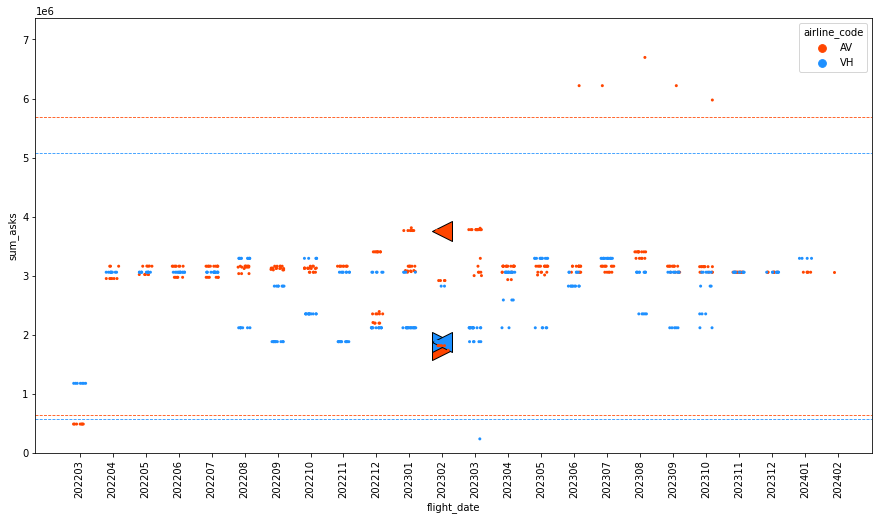

,airline_code,rt,median_asks_hist,median_lower_thresh_hist,median_upper_thresh_hist
173,AV,MDERCH,3159811.72,631962.344,5687661.096
480,VH,MDERCH,2822660.64,564532.128,5080789.152


Out[37]: 70.49

In [ ]:
total_time_execution_secs = round((time.time() - start_time),2)
total_time_execution_secs

# XX. Espacio de prueba